In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import cartopy.feature as cfea

In [9]:
def worldmap(img):
    projection = ccrs.PlateCarree(central_longitude=0)
    img_extent = (-180, 180, -90, 90)

    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    im = ax.imshow(img,
                   origin='upper',
                   extent=img_extent,
                   transform=projection,
                   vmin=0, vmax=1e2)
    fig.colorbar(im, ax=ax)

In [10]:
def worldmap_norm(data, vmin=1e-30):
    projection = ccrs.PlateCarree(central_longitude=0)
    img_extent = (-180, 180, -90, 90)
    
    log_norm = LogNorm(vmin=vmin, vmax=data.max())
    #log_norm_data = log_norm(data, clip=True)

    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    im = ax.imshow(data,
                   origin='upper',
                   extent=img_extent,
                   transform=projection,
                   cmap='GnBu',
                   norm=log_norm)
    fig.colorbar(im, ax=ax, orientation='horizontal')

In [11]:
def load(name, SUF='.hlf', day=356, second=86400, coef=1e12):
    if SUF == '.hlf':
        shape = (360, 720)
        areapath = '/home/kajiyama/H08/H08_20230612/map/dat/lnd_ara_/lndara.WFDEI.hlf'
        maskpath = '/home/kajiyama/H08/H08_20230612/map/dat/lnd_msk_/lndmsk.WFDEI.hlf'
    elif SUF == '.gl5':
        shape = (2160, 4320)
        areapath = '/home/kajiyama/H08/H08_20230612/map/dat/lnd_ara_/lndara.CAMA.gl5'
        maskpath = '/home/kajiyama/H08/H08_20230612/map/dat/lnd_msk_/lndmsk.CAMA.gl5'
    dtype = 'float32' # 4バイト
    h08dir = '/home/kajiyama/H08/H08_20230612/'
    file = h08dir + name
    
    # data
    data = np.fromfile(file, dtype=dtype)
    lonlat = data.reshape(shape)
    
    # mask out
    mask = np.fromfile(maskpath, dtype=dtype)
    mask = mask.reshape(shape)
    lonlat = np.ma.masked_where(mask==0, lonlat)
    lonlat = np.ma.masked_where(lonlat>1e19, lonlat)
    
    return lonlat

In [70]:
def crop(data, lat_start, lat_end, lon_start, lon_end):
    data_flipped = np.flipud(data)
    data_cropped = data_flipped[lat_start:lat_end, lon_start:lon_end]
    cropped_flipped = np.flipud(data_cropped)
    return cropped_flipped

In [47]:
# open city information text
cty_inf_ = '/home/kajiyama/H08/H08_20230612/map/dat/cty_msk_/cityrange_list03.txt'
with open(cty_inf_, "r") as file:
    line = file.readline().strip()
    
    parts = line.split()
    city_num = parts[0].zfill(3)
    print(f"city_num {city_num}")
    city = parts[5].replace("\"", "").replace("?", "").replace("/", "")
    lonmin = float(parts[6])
    lonmax = float(parts[7])
    latmin = float(parts[8])
    latmax = float(parts[9])
    
    # Dimension of the data
    a = 2160
    b = 4320
    
    ### Define the latitudes and longitudes
    # West from UK is negative 0 <= lon <= -180
    # East from UK is positive 0 <= lon <= 180
    # small value to larger value (34-36, 138-140)
    lat = np.linspace(-90, 90, a+1)
    lon = np.linspace(-180, 180, b+1)
    
    # calculate the indices correspondignt to the desired lat and lon
    lat_start, lat_end = np.searchsorted(lat, [latmin, latmax])
    lon_start, lon_end = np.searchsorted(lon, [lonmin, lonmax])
    
    ### adjust to 0.25 grid
    # lat
    if lat_start%3 == 0:
        lat_start = lat_start
    elif lat_start%3 == 1:
        lat_start -= 1
    elif lat_start%3 == 2:
        lat_start += 1
    
    # lon
    if lon_start%3 == 0:
        lon_start = lon_start
    elif lon_start%3 == 1:
        lon_start -= 1
    elif lon_start%3 == 2:
        lon_start += 1
    
    # 24 grid x 24 grid
    lat_end = lat_start + 24
    lon_end = lon_start + 24
    
    # convert real lonlat to h08 lonlat
    latmin_gl5 = lat[lat_start]
    latmax_gl5 = lat[lat_end]
    lonmin_gl5 = lon[lon_start]
    lonmax_gl5 = lon[lon_end]

city_num 001


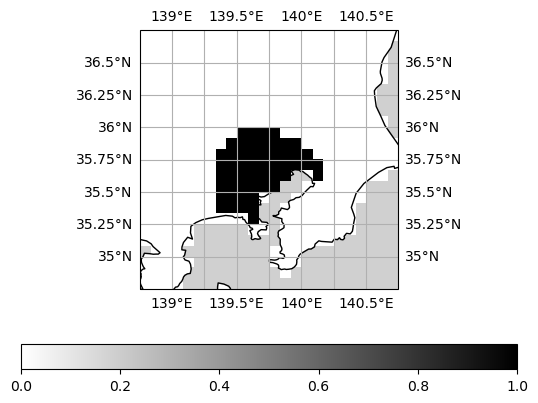

In [71]:
# 都市マスク
# flip
tokyo = load('map/dat/cty_msk_/city_00000001.gl5', SUF='.gl5')
tokyo_cropped = crop(tokyo, lat_start, lat_end, lon_start, lon_end)

# extent
projection = ccrs.PlateCarree()
img_extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)

# figure
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfea.OCEAN, color='#d0d0d0')
im = ax.imshow(tokyo_cropped,
               origin='upper',
               extent=img_extent,
               transform=projection,
               cmap='gray_r')
fig.colorbar(im, ax=ax, orientation='horizontal')

In [62]:
# 都市のマスク内の水需要の内訳
# AGR灌漑用水　InD工業用水 Dom生活用水

# TOKYO

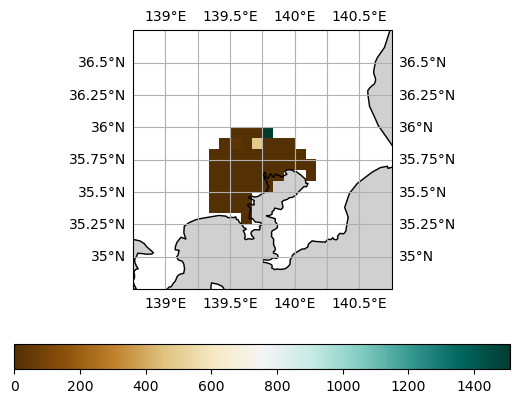

In [97]:
# load demagr tokyo
demagr = load('lnd/out/DemAgr__/W5E5LECD20190000.gl5', SUF='.gl5')
demagr_cropped = crop(demagr, lat_start, lat_end, lon_start, lon_end)

# city mask
masked_demagr = np.where(tokyo_cropped == 1, demagr_cropped, np.nan)

# extent
projection = ccrs.PlateCarree()
img_extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)

# figure
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfea.OCEAN, color='#d0d0d0')
im = ax.imshow(masked_demagr,
               origin='upper',
               extent=img_extent,
               transform=projection,
               cmap='BrBG'
               #cmap='GnBu',
               #norm = LogNorm(vmin=1e-10, vmax=1e2),
              )
fig.colorbar(im, ax=ax, orientation='horizontal')

In [ ]:
# load demagr tokyo
demagr = load('lnd/out/DemAgr__/W5E5LECD20190000.gl5', SUF='.gl5')
demagr_cropped = crop(demagr, lat_start, lat_end, lon_start, lon_end)

# city mask
masked_demagr = np.where(tokyo_cropped == 1, demagr_cropped, np.nan)

# extent
projection = ccrs.PlateCarree()
img_extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)

# figure
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfea.OCEAN, color='#d0d0d0')
im = ax.imshow(masked_demagr,
               origin='upper',
               extent=img_extent,
               transform=projection,
               cmap='BrBG'
               #cmap='GnBu',
               #norm = LogNorm(vmin=1e-10, vmax=1e2),
              )
fig.colorbar(im, ax=ax, orientation='horizontal')

In [7]:
# 都市の取水源割合の比較
# 地表水需要: river, Aqueduct, Reservoir, sf_Deficit(不足分),
# 地下水需要: Groundwater, gw_Deficit(不足分)

In [6]:
# 各都市グリッドでの導水路からの取水量

In [ ]:
# 都市の表層不足量の上位20都市(取水点探索距離最大6グリッド)